# Optimisation de code avec cffi, numba, cython

L'idée est de recoder une fonction en C. On prend comme exemple la fonction de prédiction de la régression linéaire de [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) et de prévoir le gain de temps qu'on obtient en recodant la fonction dans un langage plus rapide.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
memo_time = []
import timeit

def unit(x):
    if x >= 1: return "%1.2f s" % x
    elif x >= 1e-3: return "%1.2f ms" % (x* 1000)
    elif x >= 1e-6: return "%1.2f µs" % (x* 1000**2)
    elif x >= 1e-9: return "%1.2f ns" % (x* 1000**3)
    else:
        return "%1.2g s" % x

def timeexe(legend, code, number=100, repeat=1000):
    rep = timeit.repeat(code, number=number, repeat=repeat, globals=globals())
    ave = sum(rep) / (number * repeat)
    std = (sum((x/number - ave)**2 for x in rep) / repeat)**0.5
    fir = rep[0]/number
    fir3 = sum(rep[:3]) / (3 * number)
    las3 = sum(rep[-3:]) / (3 * number)
    rep.sort()
    mini = rep[len(rep)//20] / number
    maxi = rep[-len(rep)//20] / number
    print("Moyenne: %s Ecart-type %s (with %d runs) in [%s, %s]" % (
                unit(ave), unit(std), number, unit(mini), unit(maxi)))
    return dict(legend=legend, average=ave, deviation=std, first=fir, first3=fir3,
                last3=las3, repeat=repeat, min5=mini, max5=maxi, code=code, run=number)

## Régression linéaire

In [3]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
diabetes_X_train = diabetes.data[:-20]
diabetes_X_test  = diabetes.data[-20:]
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test  = diabetes.target[-20:]

In [4]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(diabetes_X_train, diabetes_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
clr.coef_

array([ 3.03499549e-01, -2.37639315e+02,  5.10530605e+02,  3.27736980e+02,
       -8.14131709e+02,  4.92814588e+02,  1.02848452e+02,  1.84606489e+02,
        7.43519617e+02,  7.60951722e+01])

In [6]:
clr.intercept_

152.76430691633442

In [7]:
z = diabetes_X_test[0:1,:]
memo_time.append(timeexe("sklearn.predict", "clr.predict(z)"))

Moyenne: 79.21 µs Ecart-type 22.31 µs (with 100 runs) in [51.07 µs, 122.22 µs]


In [8]:
%timeit clr.predict(z)

77.4 µs ± 2.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### optimisation avec cffi

On s'inspire de l'exemple [Purely for performance (API level, out-of-line)](http://cffi.readthedocs.io/en/latest/overview.html?highlight=example#purely-for-performance-api-level-out-of-line).

In [9]:
from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef("int linreg(int, double *, double *, double, double *);")

ffibuilder.set_source("_linear_regression",
r"""
    static int linreg(int dimension, double * x, double *coef, double intercept, double * out)
    {
        for(; dimension > 0; --dimension, ++x, ++coef)
            intercept += *x * *coef;
        *out = intercept;
        return 1;
    }
""")

ffibuilder.compile(verbose=True)

generating .\_linear_regression.c
(already up-to-date)
the current directory is 'C:\\xavierdupre\\__home_\\GitHub\\ensae_teaching_cs\\_doc\\notebooks\\2a'
running build_ext
building '_linear_regression' extension
C:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -Ic:\python372_x64\include -Ic:\python372_x64\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.6.1\include\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\winrt" "-IC:\Program Files (x86)\Windows Ki

'C:\\xavierdupre\\__home_\\GitHub\\ensae_teaching_cs\\_doc\\notebooks\\2a\\_linear_regression.cp37-win_amd64.pyd'

La fonction compilée est accessible comme suit.

In [10]:
from _linear_regression import ffi, lib
lib.linreg

<function _linear_regression.CompiledLib.linreg>

On s'inspire de l'exemple [How to pass a Numpy array into a cffi function and how to get one back out?](https://stackoverflow.com/questions/16276268/how-to-pass-a-numpy-array-into-a-cffi-function-and-how-to-get-one-back-out).

In [11]:
import numpy
out = numpy.zeros(1)

In [12]:
ptr_coef = clr.coef_.__array_interface__['data'][0]
cptr_coef = ffi.cast ( "double*" , ptr_coef )

In [13]:
x = diabetes_X_test[0:1,:]
ptr_x = x.__array_interface__['data'][0]
cptr_x = ffi.cast ( "double*" , ptr_x )

In [14]:
ptr_out = out.__array_interface__['data'][0]
cptr_out = ffi.cast ( "double*" , ptr_out )

In [15]:
n = len(clr.coef_)
lib.linreg(n, cptr_x, cptr_coef, clr.intercept_, cptr_out)

1

In [16]:
out

array([197.61846908])

On vérifie qu'on obtient bien la même chose.

In [17]:
clr.predict(x)

array([197.61846908])

Et on mesure le temps d'exécution :

In [18]:
memo_time.append(timeexe("cffi-linreg", "lib.linreg(n, cptr_x, cptr_coef, clr.intercept_, cptr_out)"))

Moyenne: 922.46 ns Ecart-type 835.86 ns (with 100 runs) in [513.00 ns, 1.36 µs]


C'est beaucoup plus rapide. Pour être totalement honnête, il faut mesurer les étapes qui consiste à extraire les pointeurs.

In [19]:
def predict_clr(x, clr):
    out = numpy.zeros(1)
    ptr_coef = clr.coef_.__array_interface__['data'][0]
    cptr_coef = ffi.cast ( "double*" , ptr_coef )
    ptr_x = x.__array_interface__['data'][0]
    cptr_x = ffi.cast ( "double*" , ptr_x )  
    ptr_out = out.__array_interface__['data'][0]
    cptr_out = ffi.cast ( "double*" , ptr_out ) 
    lib.linreg(len(x), cptr_x, cptr_coef, clr.intercept_, cptr_out)
    return out

predict_clr(x, clr)

array([152.74058378])

In [20]:
memo_time.append(timeexe("cffi-linreg-wrapped", "predict_clr(x, clr)"))

Moyenne: 16.03 µs Ecart-type 5.63 µs (with 100 runs) in [8.77 µs, 27.25 µs]


Cela reste plus rapide.

### cffi - seconde version

Comme on construit la fonction en dynamique (le code est connu lors de l'exécution), on peut facilement se passer de la boucle et écrire le code sans boucle et avec les coefficients.

In [21]:
res = " + ".join("{0}*x[{1}]".format(c, i) for i, c in enumerate(clr.coef_))
res

'0.3034995490657413*x[0] + -237.6393153335348*x[1] + 510.53060543622456*x[2] + 327.73698040934715*x[3] + -814.1317093725389*x[4] + 492.8145879837313*x[5] + 102.84845219167991*x[6] + 184.60648905984044*x[7] + 743.5196167505418*x[8] + 76.09517221662408*x[9]'

In [22]:
code = """
    static int linreg_custom(double * x, double * out)
    {{
        out[0] = {0} + {1};
    }}
""".format(clr.intercept_, res)
print(code)


    static int linreg_custom(double * x, double * out)
    {
        out[0] = 152.76430691633442 + 0.3034995490657413*x[0] + -237.6393153335348*x[1] + 510.53060543622456*x[2] + 327.73698040934715*x[3] + -814.1317093725389*x[4] + 492.8145879837313*x[5] + 102.84845219167991*x[6] + 184.60648905984044*x[7] + 743.5196167505418*x[8] + 76.09517221662408*x[9];
    }



In [23]:
from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef("int linreg_custom(double *, double *);")
ffibuilder.set_source("_linear_regression_custom", code)
ffibuilder.compile(verbose=True)

generating .\_linear_regression_custom.c
the current directory is 'C:\\xavierdupre\\__home_\\GitHub\\ensae_teaching_cs\\_doc\\notebooks\\2a'
running build_ext
building '_linear_regression_custom' extension
C:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -Ic:\python372_x64\include -Ic:\python372_x64\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.6.1\include\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\winrt" "-IC:\Program Files (x86)\Windows Kits\10\i

'C:\\xavierdupre\\__home_\\GitHub\\ensae_teaching_cs\\_doc\\notebooks\\2a\\_linear_regression_custom.cp37-win_amd64.pyd'

In [24]:
from _linear_regression_custom.lib import linreg_custom
linreg_custom(cptr_x, cptr_out)
out

array([197.61846908])

In [25]:
memo_time.append(timeexe("cffi-linreg-custom", "linreg_custom(cptr_x, cptr_out)"))

Moyenne: 646.69 ns Ecart-type 676.62 ns (with 100 runs) in [390.00 ns, 1.17 µs]


On a gagné un facteur 2.

In [26]:
def predict_clr_custom(x):
    out = numpy.zeros(1)
    ptr_x = x.__array_interface__['data'][0]
    cptr_x = ffi.cast("double*", ptr_x)
    ptr_out = out.__array_interface__['data'][0]
    cptr_out = ffi.cast("double*", ptr_out)
    linreg_custom(cptr_x, cptr_out)
    return out

predict_clr_custom(x)

array([197.61846908])

In [27]:
memo_time.append(timeexe("cffi-linreg-custom wrapped", "predict_clr_custom(x)"))

Moyenne: 11.64 µs Ecart-type 4.67 µs (with 100 runs) in [5.88 µs, 20.57 µs]


C'est un peu plus rapide.

### et en float?

L'ordinateur fait la distinction entre les [double](https://en.wikipedia.org/wiki/Double-precision_floating-point_format) code sur 64 bit et les [float](https://en.wikipedia.org/wiki/Single-precision_floating-point_format) codé sur 32 bits. La précision est meilleure dans le premier cas et les calculs sont plus rapides dans le second. Dans le cas du machine learning, on préfère la rapidité à une perte précision en précision qui est souvent compensée par l'optimisation inhérente à tout problème de machine learning. Ce qu'on perd sur une observation, on le retrouve sur une autre.

In [28]:
res = " + ".join("{0}f*x[{1}]".format(c, i) for i, c in enumerate(clr.coef_))
res

'0.3034995490657413f*x[0] + -237.6393153335348f*x[1] + 510.53060543622456f*x[2] + 327.73698040934715f*x[3] + -814.1317093725389f*x[4] + 492.8145879837313f*x[5] + 102.84845219167991f*x[6] + 184.60648905984044f*x[7] + 743.5196167505418f*x[8] + 76.09517221662408f*x[9]'

In [29]:
code = """
    static int linreg_custom_float(float * x, float * out)
    {{
        out[0] = {0}f + {1};
    }}
""".format(clr.intercept_, res)
print(code)


    static int linreg_custom_float(float * x, float * out)
    {
        out[0] = 152.76430691633442f + 0.3034995490657413f*x[0] + -237.6393153335348f*x[1] + 510.53060543622456f*x[2] + 327.73698040934715f*x[3] + -814.1317093725389f*x[4] + 492.8145879837313f*x[5] + 102.84845219167991f*x[6] + 184.60648905984044f*x[7] + 743.5196167505418f*x[8] + 76.09517221662408f*x[9];
    }



In [30]:
from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef("int linreg_custom_float(float *, float *);")
ffibuilder.set_source("_linear_regression_custom_float", code)
ffibuilder.compile(verbose=True)

generating .\_linear_regression_custom_float.c
the current directory is 'C:\\xavierdupre\\__home_\\GitHub\\ensae_teaching_cs\\_doc\\notebooks\\2a'
running build_ext
building '_linear_regression_custom_float' extension
C:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -Ic:\python372_x64\include -Ic:\python372_x64\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.6.1\include\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\winrt" "-IC:\Program Files (x86)\Windo

'C:\\xavierdupre\\__home_\\GitHub\\ensae_teaching_cs\\_doc\\notebooks\\2a\\_linear_regression_custom_float.cp37-win_amd64.pyd'

In [31]:
from _linear_regression_custom_float.lib import linreg_custom_float

In [32]:
def predict_clr_custom_float(x):
    out = numpy.zeros(1, dtype=numpy.float32)
    ptr_x = x.__array_interface__['data'][0]
    cptr_x = ffi.cast ( "float*" , ptr_x )  
    ptr_out = out.__array_interface__['data'][0]
    cptr_out = ffi.cast ( "float*" , ptr_out ) 
    linreg_custom_float(cptr_x, cptr_out)
    return out

Avant d'appeler la fonction, on doit transformer le vecteur iniatial en [float32](https://docs.scipy.org/doc/numpy/user/basics.types.html).

In [33]:
x32 = x.astype(numpy.float32)
predict_clr_custom(x32)

array([152.76430692])

In [34]:
memo_time.append(timeexe("cffi-linreg-custom-float wrapped", "predict_clr_custom(x32)"))

Moyenne: 11.84 µs Ecart-type 7.27 µs (with 100 runs) in [6.11 µs, 21.36 µs]


La différence n'est pas flagrante. Mesurons le code C uniquement même si la partie Python ne peut pas être complètement évitée.

In [35]:
out = numpy.zeros(1, dtype=numpy.float32)
ptr_x = x32.__array_interface__['data'][0]
cptr_x = ffi.cast ( "float*" , ptr_x )  
ptr_out = out.__array_interface__['data'][0]
cptr_out = ffi.cast ( "float*" , ptr_out ) 

memo_time.append(timeexe("cffi-linreg-custom-float32", "linreg_custom_float(cptr_x, cptr_out)"))

Moyenne: 557.92 ns Ecart-type 637.89 ns (with 100 runs) in [384.00 ns, 941.00 ns]


La différence n'est pas significative.

### SIMD

C'est un ensemble d'instructions processeur pour faire des opérations terme à terme sur 4 float32 aussi rapidement qu'une seule. Le processeur ne peut faire des opérations que les nombres sont copiés dans ses registres. Le programme passe alors son temps à copier des nombres depuis la mémoire vers les registres du processeur puis à faire la copie dans le chemin inverse pour le résultat. Les instructions [SIMD](https://en.wikipedia.org/wiki/SIMD) font gagner du temps du niveau du calcul. Au lieu de faire 4 opérations de multiplication terme à terme, il n'en fait plus qu'une. Il suffit de savoir comment utiliser ces instructions. Avec Visual Studio, elles sont accessible via ces fonctions [Memory and Initialization Using Streaming SIMD Extensions](https://msdn.microsoft.com/en-us/library/0hey67c0%28v=vs.100%29.aspx).
Le code suivant n'est probablement pas optimal mais il n'est pas trop compliqué à suivre.

In [36]:
code = """
#include <xmmintrin.h> 

static int linreg_custom_float_simd(float * x, float * out)
{
    __m128 c1 = _mm_set_ps(0.3034995490664121f, -237.63931533353392f, 510.5306054362245f, 327.7369804093466f);
    __m128 c2 = _mm_set_ps(-814.1317093725389f, 492.81458798373245f, 102.84845219168025f, 184.60648905984064f);
    __m128 r1 = _mm_set_ss(152.76430691633442f);
    r1 = _mm_add_ss(r1, _mm_mul_ps(c1, _mm_load_ps(x)));
    r1 = _mm_add_ss(r1, _mm_mul_ps(c2, _mm_load_ps(x+4)));
    float r[4];
    _mm_store_ps(r, r1);    
    out[0] = r[0] + r[1] + r[2] + r[3] + 743.5196167505419f * x[8] + 76.095172216624f * x[9];
    return 1;
}
"""

In [37]:
from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef("int linreg_custom_float_simd(float *, float *);")
ffibuilder.set_source("_linear_regression_custom_float_simd", code)
ffibuilder.compile(verbose=True)

generating .\_linear_regression_custom_float_simd.c
(already up-to-date)
the current directory is 'C:\\xavierdupre\\__home_\\GitHub\\ensae_teaching_cs\\_doc\\notebooks\\2a'
running build_ext
building '_linear_regression_custom_float_simd' extension
C:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -Ic:\python372_x64\include -Ic:\python372_x64\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.6.1\include\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\winrt" 

'C:\\xavierdupre\\__home_\\GitHub\\ensae_teaching_cs\\_doc\\notebooks\\2a\\_linear_regression_custom_float_simd.cp37-win_amd64.pyd'

In [38]:
from _linear_regression_custom_float_simd.lib import linreg_custom_float_simd

In [39]:
out = numpy.zeros(1, dtype=numpy.float32)
ptr_x = x32.__array_interface__['data'][0]
cptr_x = ffi.cast ( "float*" , ptr_x )  
ptr_out = out.__array_interface__['data'][0]
cptr_out = ffi.cast ( "float*" , ptr_out ) 

linreg_custom_float_simd(cptr_x, cptr_out)
out

array([171.1178], dtype=float32)

In [40]:
memo_time.append(timeexe("cffi-linreg-custom-float32-simd", "linreg_custom_float_simd(cptr_x, cptr_out)"))

Moyenne: 610.13 ns Ecart-type 238.21 ns (with 100 runs) in [323.00 ns, 783.00 ns]


C'est légèrement mieux, quelques références :

* [aligned_vs_unaligned_load.c](https://gist.github.com/rmcgibbo/7689820) : c'est du code mais facile à lire.
* [How to Write Fast Numerical Code](https://www.inf.ethz.ch/personal/markusp/teaching/263-2300-ETH-spring11/slides/class17.pdf)

Les processeurs évoluent au fil du temps, 4 float, 8 float, [SIMD2](https://msdn.microsoft.com/en-us/library/kcwz153a%28v=vs.100%29.aspx), [FMA4 Intrinsics Added for Visual Studio 2010 SP1](https://msdn.microsoft.com/en-us/library/gg445134%28v=vs.100%29.aspx), [AVX](https://software.intel.com/en-us/articles/introduction-to-intel-advanced-vector-extensions/).

### Réécriture purement Python

On continue avec uniquement du Python sans numpy.

In [41]:
coef = clr.coef_
list(coef)

[0.3034995490657413,
 -237.6393153335348,
 510.53060543622456,
 327.73698040934715,
 -814.1317093725389,
 492.8145879837313,
 102.84845219167991,
 184.60648905984044,
 743.5196167505418,
 76.09517221662408]

In [42]:
code = str(clr.intercept_) + "+" + "+".join("x[{0}]*({1})".format(i, c) for i, c in enumerate(coef))
code

'152.76430691633442+x[0]*(0.3034995490657413)+x[1]*(-237.6393153335348)+x[2]*(510.53060543622456)+x[3]*(327.73698040934715)+x[4]*(-814.1317093725389)+x[5]*(492.8145879837313)+x[6]*(102.84845219167991)+x[7]*(184.60648905984044)+x[8]*(743.5196167505418)+x[9]*(76.09517221662408)'

In [43]:
def predict_clr_python(x):
    return 152.764306916+x[0]*0.3034995490664121+x[1]*(-237.63931533353392)+x[2]*510.5306054362245+ \
            x[3]*327.7369804093466+ \
            x[4]*(-814.1317093725389)+x[5]*492.81458798373245+x[6]*102.84845219168025+ \
            x[7]*184.60648905984064+x[8]*743.5196167505419+x[9]*76.095172216624
            
predict_clr_python(x[0])

197.61846907469848

In [44]:
z = list(x[0])
memo_time.append(timeexe("python-linreg-custom", "predict_clr_python(z)"))

Moyenne: 5.48 µs Ecart-type 2.11 µs (with 100 runs) in [3.15 µs, 9.04 µs]


De façon assez surprenante, c'est plutôt rapide. Et si on y mettait une boucle.

In [45]:
def predict_clr_python_loop(x, coef, intercept):    
    return intercept + sum(a*b for a, b in zip(x, coef))
            
predict_clr_python_loop(x[0], list(clr.coef_), clr.intercept_)

197.61846907503283

In [46]:
coef = list(clr.coef_)
intercept = clr.intercept_
memo_time.append(timeexe("python-linreg", "predict_clr_python_loop(z, coef, intercept)"))

Moyenne: 8.79 µs Ecart-type 4.94 µs (with 100 runs) in [4.48 µs, 18.63 µs]


A peine plus long.

### Réécriture avec Python et numpy

In [47]:
def predict_clr_numpy(x, coef, intercept):    
    return intercept + numpy.dot(coef, x).sum()
            
predict_clr_numpy(x[0], clr.coef_, clr.intercept_)

197.61846907503283

In [48]:
memo_time.append(timeexe("numpy-linreg-numpy", "predict_clr_numpy(z, coef, clr.intercept_)"))

Moyenne: 14.68 µs Ecart-type 6.32 µs (with 100 runs) in [9.01 µs, 27.98 µs]


Les dimensions des tableaux sont trop petites pour que le calcul matriciel apporte une différence. On se retrouve dans le cas *cffi* où les échanges Python - C grignotent tout le temps de calcul.

### numba

[numba](http://numba.pydata.org/) essaye de compiler à la volée des bouts de codes écrits en Python. On induque quelle fonction optimiser en faisant précéder la fonction de ``@jit``. Toutes les écritures ne fonctionnent, typiquement, certaines listes en compréhension soulèvent une exception. Il faut donc écrire son code en Python d'une façon assez proche de ce qu'il serait en C.

In [49]:
from numba import jit

In [50]:
@jit
def predict_clr_numba(x, coef, intercept):
    s = intercept
    for i in range(0, len(x)):
        s += coef[i] * x[i]
    return s
            
predict_clr_numba(z, clr.coef_, clr.intercept_)

197.6184690750328

In [51]:
memo_time.append(timeexe("numba-linreg-notype", "predict_clr_numba(z, clr.coef_, clr.intercept_)"))

Moyenne: 48.67 µs Ecart-type 18.92 µs (with 100 runs) in [26.29 µs, 80.64 µs]


Plutôt rapide !

In [52]:
@jit('double(double[:], double[:], double)')
def predict_clr_numba_cast(x, coef, intercept):
    s = intercept
    for i in range(0, len(x)):
        s += coef[i] * x[i]
    return s
            
# La fonction ne fonctionne qu'avec un numpy.array car le langage C est fortement typé.
predict_clr_numba_cast(x[0], clr.coef_, clr.intercept_)

197.6184690750328

In [53]:
memo_time.append(timeexe("numba-linreg-type", "predict_clr_numba_cast(x[0], clr.coef_, clr.intercept_)"))

Moyenne: 1.61 µs Ecart-type 1.03 µs (with 100 runs) in [998.00 ns, 2.69 µs]


On voit que plus on donne d'information au compilateur, plus il est capable d'optimiser.

In [54]:
@jit('float32(float32[:], float32[:], float32)')
def predict_clr_numba_cast_float(x, coef, intercept):
    s = intercept
    for i in range(0, len(x)):
        s += coef[i] * x[i]
    return s
            
# La fonction ne fonctionne qu'avec un numpy.array car le langage C est fortement typé.
x32 = x[0].astype(numpy.float32)
c32 = clr.coef_.astype(numpy.float32)
i32 = numpy.float32(clr.intercept_)
predict_clr_numba_cast_float(x32, c32, i32)

197.61846923828125

In [55]:
memo_time.append(timeexe("numba-linreg-type-float32", "predict_clr_numba_cast_float(x32, c32, i32)"))

Moyenne: 941.96 ns Ecart-type 535.21 ns (with 100 runs) in [637.00 ns, 1.55 µs]


On essaye avec les coefficients dans la fonction.

In [56]:
@jit('double(double[:])')
def predict_clr_numba_cast_custom(x):
    coef = [ 3.03499549e-01, -2.37639315e+02,  5.10530605e+02,  3.27736980e+02,
            -8.14131709e+02,  4.92814588e+02,  1.02848452e+02,  1.84606489e+02,
             7.43519617e+02,  7.60951722e+01]
    s = 152.76430691633442
    for i in range(0, len(x)):
        s += coef[i] * x[i]
    return s
            
predict_clr_numba_cast_custom(x[0])

197.61846907190048

In [57]:
memo_time.append(timeexe("numba-linreg-type-custom", "predict_clr_numba_cast_custom(x[0])"))

Moyenne: 1.36 µs Ecart-type 1.18 µs (with 100 runs) in [842.00 ns, 2.29 µs]


On se rapproche des temps obtenus avec *cffi* sans *wrapping*, cela signifie que *numba* fait un bien meilleur travail à ce niveau que le wrapper rapidement créé.

In [58]:
@jit('double(double[:], double[:], double)')
def predict_clr_numba_numpy(x, coef, intercept):    
    return intercept + numpy.dot(coef, x).sum()

predict_clr_numba_numpy(x[0], clr.coef_, clr.intercept_)

197.61846907503283

In [59]:
memo_time.append(timeexe("numba-linreg-type-numpy", "predict_clr_numba_numpy(x[0], clr.coef_, clr.intercept_)"))

Moyenne: 13.76 µs Ecart-type 6.01 µs (with 100 runs) in [7.52 µs, 23.82 µs]


*numba* est moins performant quand *numpy* est impliqué car le code de numpy n'est pas réécrit, il est appelé.

### cython

[cython](http://cython.org/) permet de créer des extensions C de plus grande envergure que *numba*. C'est l'option choisie par [scikit-learn](http://scikit-learn.org/stable/). Il vaut mieux connaître le C pour s'en servir et là encore, l'objectif est de réduire les échanges Python / C qui coûtent cher.

In [60]:
%load_ext cython

In [61]:
%%cython
def predict_clr_cython(x, coef, intercept):
    s = intercept
    for i in range(0, len(x)):
        s += coef[i] * x[i]
    return s

In [62]:
predict_clr_cython(x[0], clr.coef_, clr.intercept_)

197.6184690750328

In [63]:
memo_time.append(timeexe("cython-linreg", "predict_clr_cython(x[0], clr.coef_, clr.intercept_)"))

Moyenne: 7.19 µs Ecart-type 2.42 µs (with 100 runs) in [4.15 µs, 11.76 µs]


Cython fait moins bien que *numba* dans notre cas et l'optimisation proposée est assez proche du temps déjà obtenue avec le langage Python seul. Cela est dû au fait que la plupart des objets tels que du code associé aux listes ou aux dictionnaires ont été réécrits en C.

In [64]:
%%cython
cimport numpy as npc

def predict_clr_cython_type(npc.ndarray[double, ndim=1, mode='c'] x,
                            npc.ndarray[double, ndim=1, mode='c'] coef,
                            double intercept):
    cdef double s = intercept
    for i in range(0, x.shape[0]):
        s += coef[i] * x[i]
    return s

In [65]:
predict_clr_cython_type(x[0], clr.coef_, clr.intercept_)

197.6184690750328

In [66]:
memo_time.append(timeexe(
    "cython-linreg-type", "predict_clr_cython_type(x[0], clr.coef_, clr.intercept_)"))

Moyenne: 2.94 µs Ecart-type 1.73 µs (with 100 runs) in [1.56 µs, 5.73 µs]


Le temps est quasi identique avec un écart type moins grand de façon significative.

### Une dernière option : ONNX

[ONNX](https://onnx.ai/) est un format de sérialisation qui permet de décrire un modèle de modèle de machine learning ou de deep learning. Cela permet de dissocer le modèle de la librairie qui a servi à le produire (voir [ML.net and ONNX](http://www.xavierdupre.fr/app/machinelearningext/helpsphinx/aonnx.html)).

In [67]:
try:
    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType
    import onnxruntime
    import onnx
    ok_onnx = True
    print("onnx, skl2onnx, onnxruntime sont disponibles.")
    
    def save_model(onnx_model, filename):
        with open(filename, "wb") as f:
            f.write(onnx_model.SerializeToString())
except ImportError as e:
    print("La suite requiert onnx, skl2onnx et onnxruntime.")
    print(e)
    ok_onnx = False

onnx, skl2onnx, onnxruntime sont disponibles.


On convertit le modèle au format [ONNX](https://onnx.ai/).

In [68]:
if ok_onnx:
    onnx_model = convert_sklearn(
        clr, 'model', [('input', FloatTensorType([None, clr.coef_.shape[0]]))],
        target_opset=11)
    save_model(onnx_model, 'model.onnx')
    
    model_onnx = onnx.load('model.onnx')
    print("Modèle sérialisé au format ONNX")
    print(model_onnx)
else:
    print("onnx, onnxmltools, onnxruntime sont disponibles.")

Modèle sérialisé au format ONNX
ir_version: 6
producer_name: "skl2onnx"
producer_version: "1.6.995"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "input"
    output: "variable"
    name: "LinearRegressor"
    op_type: "LinearRegressor"
    attribute {
      name: "coefficients"
      floats: 0.3034995496273041
      floats: -237.63931274414062
      floats: 510.5306091308594
      floats: 327.7369689941406
      floats: -814.1317138671875
      floats: 492.8145751953125
      floats: 102.84844970703125
      floats: 184.6064910888672
      floats: 743.5195922851562
      floats: 76.09516906738281
      type: FLOATS
    }
    attribute {
      name: "intercepts"
      floats: 152.76431274414062
      type: FLOATS
    }
    domain: "ai.onnx.ml"
  }
  name: "model"
  input {
    name: "input"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 10
          }
        }
      }

On calcule les prédictions. Le module {onnxruntime](https://docs.microsoft.com/en-us/python/api/overview/azure/onnx/intro?view=azure-onnx-py) optimise les calculs pour des modèles de deep learning. Cela explique pourquoi tous les calculs sont réalisés avec des réels représentés sur 4 octets [numpy.float32](https://docs.scipy.org/doc/numpy/user/basics.types.html?highlight=float32).

In [69]:
if ok_onnx:
    sess = onnxruntime.InferenceSession("model.onnx")
    for i in sess.get_inputs():
        print('Input:', i)
    for o in sess.get_outputs():
        print('Output:', o)
    
    def predict_onnxrt(x):    
        return sess.run(["variable"], {'input': x})
    
    print("Prediction:", predict_onnxrt(x.astype(numpy.float32)))

Input: NodeArg(name='input', type='tensor(float)', shape=[None, 10])
Output: NodeArg(name='variable', type='tensor(float)', shape=[None, 1])
Prediction: [array([[197.61847]], dtype=float32)]


In [70]:
if ok_onnx:
    x32 = x.astype(numpy.float32)
    memo_time.append(timeexe("onnxruntime-float32", "predict_onnxrt(x32)"))
    memo_time.append(timeexe("onnxruntime-float64", "predict_onnxrt(x.astype(numpy.float32))"))

Moyenne: 17.47 µs Ecart-type 5.88 µs (with 100 runs) in [10.32 µs, 26.29 µs]
Moyenne: 19.94 µs Ecart-type 5.10 µs (with 100 runs) in [12.09 µs, 26.50 µs]


### Récapitulatif

In [71]:
import pandas
df = pandas.DataFrame(data=memo_time)
df = df.set_index("legend").sort_values("average")
df

,average,deviation,first,first3,last3,repeat,min5,max5,code,run
legend,,,,,,,,,,
cffi-linreg-custom-float32,5.579220e-07,6.378856e-07,7.053000e-06,2.821000e-06,1.054667e-06,1000,3.840000e-07,9.410000e-07,"linreg_custom_float(cptr_x, cptr_out)",100
cffi-linreg-custom-float32-simd,6.101300e-07,2.382064e-07,3.309000e-06,2.582667e-06,3.226667e-07,1000,3.230000e-07,7.830000e-07,"linreg_custom_float_simd(cptr_x, cptr_out)",100
cffi-linreg-custom,6.466910e-07,6.766165e-07,1.621000e-06,1.035333e-06,5.616667e-07,1000,3.900000e-07,1.174000e-06,"linreg_custom(cptr_x, cptr_out)",100
cffi-linreg,9.224580e-07,8.358571e-07,8.109000e-06,3.247333e-06,1.170667e-06,1000,5.130000e-07,1.359000e-06,"lib.linreg(n, cptr_x, cptr_coef, clr.intercept...",100
numba-linreg-type-float32,9.419560e-07,5.352065e-07,1.786000e-06,1.732333e-06,1.200667e-06,1000,6.370000e-07,1.551000e-06,"predict_clr_numba_cast_float(x32, c32, i32)",100
numba-linreg-type-custom,1.355201e-06,1.178526e-06,9.840000e-07,8.930000e-07,1.559667e-06,1000,8.420000e-07,2.293000e-06,predict_clr_numba_cast_custom(x[0]),100
numba-linreg-type,1.607929e-06,1.033716e-06,2.489000e-06,2.261000e-06,2.231333e-06,1000,9.980000e-07,2.687000e-06,"predict_clr_numba_cast(x[0], clr.coef_, clr.in...",100
cython-linreg-type,2.935830e-06,1.731925e-06,1.726000e-06,1.620667e-06,2.530667e-06,1000,1.560000e-06,5.733000e-06,"predict_clr_cython_type(x[0], clr.coef_, clr.i...",100
python-linreg-custom,5.480978e-06,2.107939e-06,8.329000e-06,7.804667e-06,5.764667e-06,1000,3.146000e-06,9.042000e-06,predict_clr_python(z),100


On enlève quelques colonnes et on rappelle :

* **cffi**: signifie optimisé avec cffi
* **custom**: pas de boucle mais la fonction ne peut prédire qu'une seule régression linéaire
* **float32**: utilise des float et non des double
* **linreg**: régression linéaire
* **numba**: optimisation avec numba
* **numpy**: optimisation avec numpy
* **python**: pas de C, que du python
* **simd**: optimisé avec les instructions SIMD
* **sklearn**: fonction sklearn.predict
* **static**: la fonction utilise des variables statiques
* **type**: la fonction est typée et ne fonctionne qu'avec un type précis en entrée.
* **wrapped**: code optimisé mais embabllé dans une fonction Python qui elle ne l'est pas (les containers sont recréés à chaque fois)

In [72]:
cols = ["average", "deviation", "min5", "max5", "run", "code"]
df[cols]

,average,deviation,min5,max5,run,code
legend,,,,,,
cffi-linreg-custom-float32,5.579220e-07,6.378856e-07,3.840000e-07,9.410000e-07,100,"linreg_custom_float(cptr_x, cptr_out)"
cffi-linreg-custom-float32-simd,6.101300e-07,2.382064e-07,3.230000e-07,7.830000e-07,100,"linreg_custom_float_simd(cptr_x, cptr_out)"
cffi-linreg-custom,6.466910e-07,6.766165e-07,3.900000e-07,1.174000e-06,100,"linreg_custom(cptr_x, cptr_out)"
cffi-linreg,9.224580e-07,8.358571e-07,5.130000e-07,1.359000e-06,100,"lib.linreg(n, cptr_x, cptr_coef, clr.intercept..."
numba-linreg-type-float32,9.419560e-07,5.352065e-07,6.370000e-07,1.551000e-06,100,"predict_clr_numba_cast_float(x32, c32, i32)"
numba-linreg-type-custom,1.355201e-06,1.178526e-06,8.420000e-07,2.293000e-06,100,predict_clr_numba_cast_custom(x[0])
numba-linreg-type,1.607929e-06,1.033716e-06,9.980000e-07,2.687000e-06,100,"predict_clr_numba_cast(x[0], clr.coef_, clr.in..."
cython-linreg-type,2.935830e-06,1.731925e-06,1.560000e-06,5.733000e-06,100,"predict_clr_cython_type(x[0], clr.coef_, clr.i..."
python-linreg-custom,5.480978e-06,2.107939e-06,3.146000e-06,9.042000e-06,100,predict_clr_python(z)


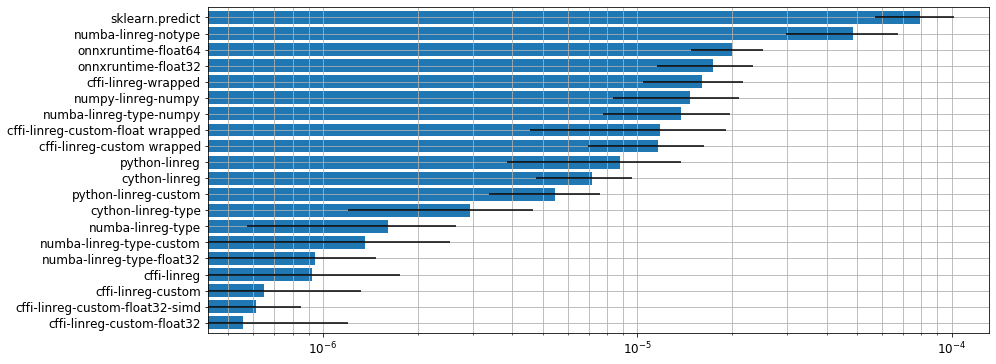

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(14,6))
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor");

Il manque à ce comparatif le [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit) mais c'est un peu plus complexe à mettre en oeuvre, il faut une carte [GPU](https://fr.wikipedia.org/wiki/Processeur_graphique) et la parallélisation n'apporterait pas énormément compte tenu de la faible dimension du problème.

### Prédiction one-off et biais de mesure

Le graphique précédent montre que la fonction ``predict`` de *scikit-learn* est la plus lente. La première raison est que ce code est valable pour toutes les régresssions linéaires alors que toutes les autres fonctions sont spécialisées pour un seul modèle. La seconde raison est que le code de *scikit-learn* est optimisé pour le calcul de plusieurs prédictions à la fois alors que toutes les autres fonctions n'en calcule qu'une seule (scénario dit *one-off*). On compare à ce que donnerait unev version purement python et numpy.

In [74]:
def predict_clr_python_loop_multi(x, coef, intercept):    
    # On s'attend à deux dimension.
    res = numpy.zeros((x.shape[0], 1))
    res[:, 0] = intercept
    for i in range(0, x.shape[0]):
        res[i, 0] += sum(a*b for a, b in zip(x[i, :], coef))
    return res

predict_clr_python_loop_multi(diabetes_X_test[:2], clr.coef_, clr.intercept_)

array([[197.61846908],
       [155.43979328]])

In [75]:
def predict_clr_numpy_loop_multi(x, coef, intercept):    
    # On s'attend à deux dimension.
    res = numpy.ones((x.shape[0], 1)) * intercept
    res += x @ coef.reshape((len(coef), 1))
    return res

predict_clr_numpy_loop_multi(diabetes_X_test[:2], clr.coef_, clr.intercept_)

array([[197.61846908],
       [155.43979328]])

In [76]:
def predict_clr_numba_cast_multi(X, coef, intercept):
    return [predict_clr_numba_cast(x, coef, intercept) for x in X]

predict_clr_numba_cast_multi(diabetes_X_test[:2], clr.coef_, clr.intercept_)

[197.6184690750328, 155.43979327521237]

In [77]:
def predict_clr_cython_type_multi(X, coef, intercept):
    return [predict_clr_cython_type(x, coef, intercept) for x in X]

predict_clr_cython_type_multi(diabetes_X_test[:2], clr.coef_, clr.intercept_)

[197.6184690750328, 155.43979327521237]

In [78]:
memo = []
batch = [1, 10, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 10000,
         20000, 50000, 75000, 100000, 150000, 200000, 300000, 400000,
         500000, 600000]
number = 10
for i in batch:
    if i <= diabetes_X_test.shape[0]:
        mx = diabetes_X_test[:i]
    else:
        mxs = [diabetes_X_test] * (i // diabetes_X_test.shape[0] + 1)
        mx = numpy.vstack(mxs)
        mx = mx[:i]

    print("batch", "=", i)
    repeat=20 if i >= 5000 else 100
    
    memo.append(timeexe("sklearn.predict %d" % i, "clr.predict(mx)", 
                        repeat=repeat, number=number))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "sklearn"
    
    if i <= 1000:
        # très lent
        memo.append(timeexe("python %d" % i, "predict_clr_python_loop_multi(mx, clr.coef_, clr.intercept_)",
                            repeat=20, number=number))
        memo[-1]["batch"] = i
        memo[-1]["lib"] = "python"
    
    memo.append(timeexe("numpy %d" % i, "predict_clr_numpy_loop_multi(mx, clr.coef_, clr.intercept_)",
                        repeat=repeat, number=number))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "numpy"
    
    if i <= 10000:
        # très lent
        memo.append(timeexe("numba %d" % i, "predict_clr_numba_cast_multi(mx, clr.coef_, clr.intercept_)",
                            repeat=repeat, number=number))
        memo[-1]["batch"] = i
        memo[-1]["lib"] = "numba"
        
    if i <= 1000:
        # très lent
        memo.append(timeexe("cython %d" % i, "predict_clr_cython_type_multi(mx, clr.coef_, clr.intercept_)",
                            repeat=repeat, number=number))
        memo[-1]["batch"] = i
        memo[-1]["lib"] = "cython"
        
    if ok_onnx:
        memo.append(timeexe("onnxruntime %d" % i, "predict_onnxrt(mx.astype(numpy.float32))",
                            repeat=repeat, number=number))
        memo[-1]["batch"] = i
        memo[-1]["lib"] = "onnxruntime"

batch = 1
Moyenne: 62.47 µs Ecart-type 25.32 µs (with 10 runs) in [43.47 µs, 124.43 µs]
Moyenne: 12.82 µs Ecart-type 952.84 ns (with 10 runs) in [10.46 µs, 13.75 µs]
Moyenne: 10.81 µs Ecart-type 2.74 µs (with 10 runs) in [9.32 µs, 15.59 µs]
Moyenne: 2.59 µs Ecart-type 366.75 ns (with 10 runs) in [2.46 µs, 2.74 µs]
Moyenne: 3.88 µs Ecart-type 1.36 µs (with 10 runs) in [3.00 µs, 6.70 µs]
Moyenne: 21.51 µs Ecart-type 10.85 µs (with 10 runs) in [12.22 µs, 43.08 µs]
batch = 10
Moyenne: 62.02 µs Ecart-type 19.96 µs (with 10 runs) in [43.78 µs, 99.00 µs]
Moyenne: 135.50 µs Ecart-type 26.93 µs (with 10 runs) in [96.31 µs, 166.30 µs]
Moyenne: 13.96 µs Ecart-type 4.22 µs (with 10 runs) in [10.10 µs, 21.03 µs]
Moyenne: 19.11 µs Ecart-type 5.97 µs (with 10 runs) in [11.26 µs, 31.73 µs]
Moyenne: 21.76 µs Ecart-type 7.48 µs (with 10 runs) in [17.09 µs, 42.77 µs]
Moyenne: 16.94 µs Ecart-type 7.20 µs (with 10 runs) in [14.29 µs, 27.28 µs]
batch = 100
Moyenne: 82.55 µs Ecart-type 19.74 µs (with 10 runs

In [79]:
dfb = pandas.DataFrame(memo)[["average", "lib", "batch"]]
piv = dfb.pivot("batch", "lib", "average")
piv

lib,cython,numba,numpy,onnxruntime,python,sklearn
batch,,,,,,
1,0.000004,0.000003,0.000011,0.000022,0.000013,0.000062
10,0.000022,0.000019,0.000014,0.000017,0.000135,0.000062
100,0.000222,0.000138,0.000019,0.000050,0.001752,0.000083
200,0.000460,0.000275,0.000023,0.000060,0.003221,0.000092
500,0.001213,0.000755,0.000021,0.000140,0.007690,0.000083
1000,0.002432,0.001598,0.000050,0.000197,0.015449,0.000121
2000,NaN,0.002941,0.000051,0.000436,NaN,0.000123
3000,NaN,0.004397,0.000040,0.000589,NaN,0.000177
4000,NaN,0.006103,0.000050,0.000779,NaN,0.000170


In [80]:
for c in piv.columns:
    piv["ave_" + c] = piv[c] / piv.index
piv

lib,cython,numba,numpy,onnxruntime,python,sklearn,ave_cython,ave_numba,ave_numpy,ave_onnxruntime,ave_python,ave_sklearn
batch,,,,,,,,,,,,
1,0.000004,0.000003,0.000011,0.000022,0.000013,0.000062,0.000004,0.000003,1.080870e-05,2.151140e-05,0.000013,6.247010e-05
10,0.000022,0.000019,0.000014,0.000017,0.000135,0.000062,0.000002,0.000002,1.396190e-06,1.693920e-06,0.000014,6.202100e-06
100,0.000222,0.000138,0.000019,0.000050,0.001752,0.000083,0.000002,0.000001,1.905660e-07,5.036020e-07,0.000018,8.254790e-07
200,0.000460,0.000275,0.000023,0.000060,0.003221,0.000092,0.000002,0.000001,1.125545e-07,3.019365e-07,0.000016,4.586410e-07
500,0.001213,0.000755,0.000021,0.000140,0.007690,0.000083,0.000002,0.000002,4.234300e-08,2.806916e-07,0.000015,1.651440e-07
1000,0.002432,0.001598,0.000050,0.000197,0.015449,0.000121,0.000002,0.000002,5.002070e-08,1.974908e-07,0.000015,1.211521e-07
2000,NaN,0.002941,0.000051,0.000436,NaN,0.000123,NaN,0.000001,2.525915e-08,2.182152e-07,NaN,6.171235e-08
3000,NaN,0.004397,0.000040,0.000589,NaN,0.000177,NaN,0.000001,1.327523e-08,1.961812e-07,NaN,5.901053e-08
4000,NaN,0.006103,0.000050,0.000779,NaN,0.000170,NaN,0.000002,1.243255e-08,1.946893e-07,NaN,4.247705e-08


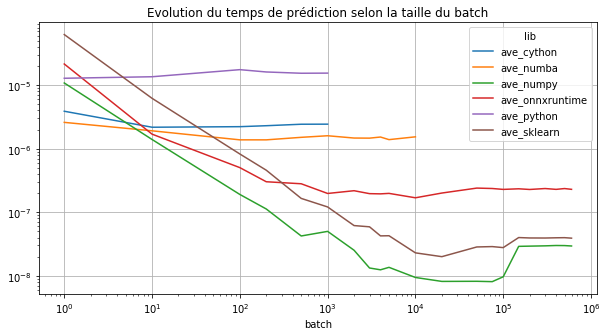

In [81]:
libs = list(c for c in piv.columns if "ave_" in c)
ax = piv.plot(y=libs, logy=True, logx=True, figsize=(10, 5))
ax.set_title("Evolution du temps de prédiction selon la taille du batch")
ax.grid(True);

Le minimum obtenu est pour $10^{-8} s$ soit 10 ns. Cela montre que la comparaisson précédente était incomplète voire biaisée. Tout dépend de l'usage qu'on fait de la fonction de prédiction même s'il sera toujours possible de d'écrire un code spécialisé plus rapide que toute autre fonction générique. En général, plus on reste du côté Python, plus le programme est lent. Le nombre de passage de l'un à l'autre, selon la façon dont il est fait ralenti aussi. En tenant compte de cela, le programme rouge sera plus lent que le vert.

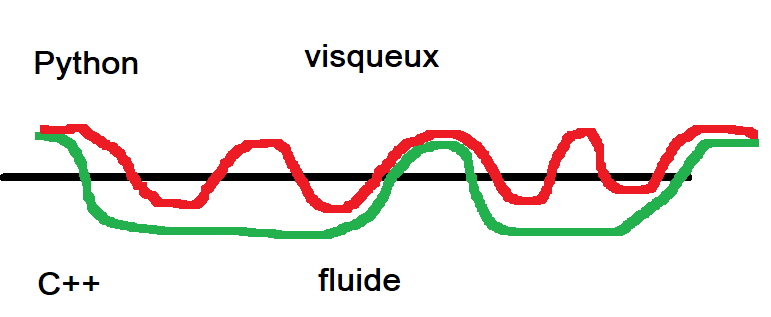

In [82]:
from pyquickhelper.helpgen import NbImage
NbImage("pycpp.png")

Ces résultats sont d'une façon générale assez volatile car le temps de calcul est enrobé dans plusieurs fonctions Python qui rendent une mesure précise difficile. Il reste néanmoins une bonne idée des ordres de grandeurs.

## Random Forest

On reproduit les mêmes résultats pour une random forest mais la réécriture n'est plus aussi simple qu'une régression linéaire.

### Une prédiction à la fois

In [83]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
diabetes_X_train = diabetes.data[:-20]
diabetes_X_test  = diabetes.data[-20:]
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test  = diabetes.target[-20:]

In [84]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10)
rf.fit(diabetes_X_train, diabetes_y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [85]:
memo_time = []
x = diabetes_X_test[:1]
memo_time.append(timeexe("sklearn-rf", "rf.predict(x)", repeat=100, number=20))

Moyenne: 1.24 ms Ecart-type 420.80 µs (with 20 runs) in [838.81 µs, 2.20 ms]


C'est beaucoup plus long que la régression linéaire. On essaye avec *onnx*.

In [86]:
if ok_onnx:
    onnxrf_model = convert_sklearn(
        rf, 'model', [('input', FloatTensorType([None, clr.coef_.shape[0]]))],
        target_opset=11)
    save_model(onnxrf_model, 'model_rf.onnx')    
    model_onnx = onnx.load('model_rf.onnx')

In [87]:
if ok_onnx:
    sess = onnxruntime.InferenceSession("model_rf.onnx")
    for i in sess.get_inputs():
        print('Input:', i)
    for o in sess.get_outputs():
        print('Output:', o)
    
    def predict_onnxrt_rf(x):    
        return sess.run(["variable"], {'input': x})

    print(predict_onnxrt_rf(x.astype(numpy.float32)))
    memo_time.append(timeexe("onnx-rf", "predict_onnxrt_rf(x.astype(numpy.float32))",
                             repeat=100, number=20))

Input: NodeArg(name='input', type='tensor(float)', shape=[None, 10])
Output: NodeArg(name='variable', type='tensor(float)', shape=[None, 1])
[array([[222.3]], dtype=float32)]
Moyenne: 28.20 µs Ecart-type 10.34 µs (with 20 runs) in [16.06 µs, 51.32 µs]


C'est beaucoup plus rapide.

In [88]:
import pandas
df2 = pandas.DataFrame(data=memo_time)
df2 = df2.set_index("legend").sort_values("average")
df2

,average,deviation,first,first3,last3,repeat,min5,max5,code,run
legend,,,,,,,,,,
onnx-rf,0.000028,0.000010,0.000055,0.000050,0.000046,100,0.000016,0.000051,predict_onnxrt_rf(x.astype(numpy.float32)),20
sklearn-rf,0.001238,0.000421,0.001054,0.000929,0.000998,100,0.000839,0.002204,rf.predict(x),20


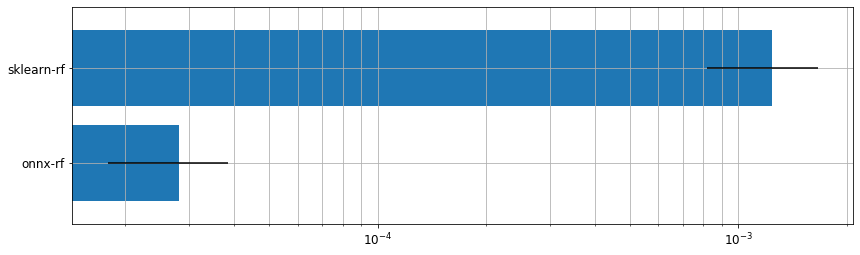

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(14,4))
df2[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                   legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor");

### Prédiction en batch

In [90]:
memo = []
batch = [1, 10, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 10000,
         20000, 50000, 75000, 100000, 150000, 200000, 300000, 400000,
         500000, 600000]
number = 10
repeat = 10
for i in batch[:15]:
    if i <= diabetes_X_test.shape[0]:
        mx = diabetes_X_test[:i]
    else:
        mxs = [diabetes_X_test] * (i // diabetes_X_test.shape[0] + 1)
        mx = numpy.vstack(mxs)
        mx = mx[:i]

    print("batch", "=", i)
    
    memo.append(timeexe("sklearn.predict %d" % i, "rf.predict(mx)", 
                        repeat=repeat, number=number))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "sklearn"
    
    if ok_onnx:
        memo.append(timeexe("onnxruntime %d" % i, 
                            "predict_onnxrt_rf(mx.astype(numpy.float32))",
                            repeat=repeat, number=number))
        memo[-1]["batch"] = i
        memo[-1]["lib"] = "onnxruntime"

batch = 1
Moyenne: 982.71 µs Ecart-type 192.57 µs (with 10 runs) in [681.34 µs, 1.38 ms]
Moyenne: 16.02 µs Ecart-type 5.24 µs (with 10 runs) in [14.18 µs, 31.75 µs]
batch = 10
Moyenne: 937.87 µs Ecart-type 136.04 µs (with 10 runs) in [681.89 µs, 1.17 ms]
Moyenne: 38.23 µs Ecart-type 20.78 µs (with 10 runs) in [21.34 µs, 83.14 µs]
batch = 100
Moyenne: 1.17 ms Ecart-type 400.72 µs (with 10 runs) in [744.35 µs, 1.98 ms]
Moyenne: 209.72 µs Ecart-type 12.82 µs (with 10 runs) in [189.36 µs, 237.52 µs]
batch = 200
Moyenne: 1.39 ms Ecart-type 493.00 µs (with 10 runs) in [796.22 µs, 2.51 ms]
Moyenne: 457.02 µs Ecart-type 101.34 µs (with 10 runs) in [305.11 µs, 589.24 µs]
batch = 500
Moyenne: 1.83 ms Ecart-type 549.57 µs (with 10 runs) in [1.17 ms, 3.11 ms]
Moyenne: 626.02 µs Ecart-type 134.81 µs (with 10 runs) in [483.93 µs, 916.82 µs]
batch = 1000
Moyenne: 1.66 ms Ecart-type 290.94 µs (with 10 runs) in [1.14 ms, 2.19 ms]
Moyenne: 1.74 ms Ecart-type 515.67 µs (with 10 runs) in [1.06 ms, 2.86 ms

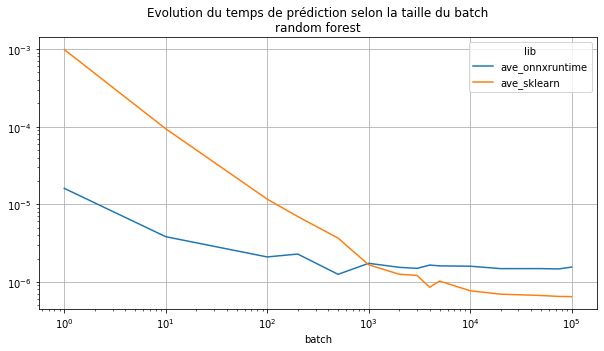

In [91]:
dfbrf = pandas.DataFrame(memo)[["average", "lib", "batch"]]
pivrf = dfbrf.pivot("batch", "lib", "average")
for c in pivrf.columns:
    pivrf["ave_" + c] = pivrf[c] / pivrf.index
libs = list(c for c in pivrf.columns if "ave_" in c)
ax = pivrf.plot(y=libs, logy=True, logx=True, figsize=(10, 5))
ax.set_title("Evolution du temps de prédiction selon la taille du batch\nrandom forest")
ax.grid(True);